In [2]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST
#import torchvision.transforms as transforms
from torch.utils.data import Dataset
import spacy
#import pytorch_lightning as pl
#from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import scipy
from sklearn.manifold import TSNE
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.svm import LinearSVC, SVR
from sklearn.multioutput import MultiOutputRegressor
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import scipy.io
import random
import inlp
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig, RobertaModel, RobertaForMaskedLM, RobertaTokenizer, RobertaConfig
from typing import Tuple, Dict
from typing import List
import tqdm
from tqdm import tqdm_notebook
import urllib
import time
import pickle
import inlp, inlp_dataset_handler, inlp_linear_model
import copy
%load_ext autoreload
%autoreload

INFO:transformers.file_utils:PyTorch version 1.4.0 available.


In [3]:
def load_wiki(url = "http://nlp.biu.ac.il/~ravfogs/resources/wiki.1million.raw.txt"):
    
  response = urllib.request.urlopen(url)
  raw = response.read().decode('utf8')
  sents = raw.split("\n")
  
  return sents[:]


def create_docs(sentences: List[str]) -> List[spacy.tokens.Doc]:

    #parsing and toekenizing (NOTE: takes about 10 minutes)
    
    nlp = spacy.load('en_core_web_sm')
    nlp.remove_pipe("ner")
    
    start = time.time()
    
    docs = list(nlp.pipe(sentences, batch_size = 100))
    
    docs = list(docs)
    print(time.time() - start)
    
    return docs


def collect_rec_dataset(docs, n):
    
    contain_rec = []
    for i, doc in tqdm_notebook(enumerate(docs), total = len(docs)):
        deps = [tok.dep_ for tok in doc]
        if "relcl" in deps:
            contain_rec.append(doc)
    
    contain_rec_set = set(contain_rec)
    no_rec = [d for d in docs if d not in contain_rec_set]
    data = []
    for i in range(n):
        
        doc_with_rec = random.choice(contain_rec)
        rec_root = random.choice([tok for tok in doc_with_rec if tok.dep_ == "relcl"])
        rec_subtree = list(rec_root.subtree)
        rec_borders = (rec_subtree[0].i, rec_subtree[-1].i)
        rec_subtree_text = [tok.text for tok in rec_subtree]
        is_reduced_relc = "that" not in rec_subtree_text and "which" not in rec_subtree_text and "who" not in rec_subtree_text and "whom" not in rec_subtree_text and "whose" not in rec_subtree_text and "where" not in rec_subtree_text 
        
        # add positive & negative examples
        
        data.append({"doc": doc_with_rec, "relc_borders": rec_borders, "is_reduced": is_reduced_relc, "relc_root_ind": rec_root.i, "label": 1})
        data.append({"doc": random.choice(no_rec), "relc_borders": None, "is_reduced": None, "relc_root_ind": None, "label": 0})
    
    random.shuffle(data)
    return data
    

In [6]:
wiki_sents = load_wiki()

In [7]:
wiki_sents = wiki_sents[:200000]
docs = create_docs(wiki_sents)

280.4957218170166


In [9]:
with open("sents.pickle", "wb") as f:
    pickle.dump(wiki_sents, f)
    
with open("docs.pickle", "wb") as f:
    pickle.dump(docs, f)

In [4]:
with open("docs.pickle", "rb") as f:
    docs = pickle.load(f)

In [7]:
docs = [d for d in docs if len(d) > 11]
data = collect_rec_dataset(docs, n = 25000)

/home/shauli/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [10]:
reduced = [d for d in data if d["is_reduced"]]
for r in reduced[:10]:
    min_ind, max_ind = r["relc_borders"]
    print(r["doc"][min_ind-3:max_ind+2])


under the premise it has been empty for at least 4 days when you emptied it minutes ago is
) in 1984 to protect the common national heritage,
every time cluebot ng reverts an edit,
not a reason to delete.
all three passes he attempted for 43 yards,
first american university to award a ph.
of the time the place of agreement was in katajanokka.
hagoromo club, to earn its jsl second division place back in 1974).
with the reception he everywhere met with from all ranks, with the extraordinary concourse of people from all parts on the occasion, and with the handsome appearance of the militia, both horse and foot.


## Encoder

In [11]:
class BertEncoder(object):
    
    def __init__(self, device = 'cpu'):

        config = BertConfig.from_pretrained("bert-large-uncased-whole-word-masking", output_hidden_states=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking')
        self.model = BertModel.from_pretrained('bert-large-uncased-whole-word-masking', config = config)
        
        #config = RobertaConfig.from_pretrained("roberta-base", output_hidden_states=True)
        #self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        #self.model = RobertaModel.from_pretrained('roberta-base', config = config)
            
        self.model.eval()
        self.model.to(device)
        self.device = device
        
    def tokenize(self, original_sentence: List[str]) -> Tuple[List[str], Dict[int, int]]:

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """

        bert_tokens = ["[CLS]"]
        orig_to_tok_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = self.tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        bert_tokens.append("[SEP]")
        
        return (bert_tokens, orig_to_tok_map)

    
    def encode(self, sentence: str, layers: List[int]):
        
        tokenized_text, orig2tok = self.tokenize(sentence.split(" "))
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            predictions = torch.cat([outputs[2][l] for l in layers], axis = 2).detach().cpu().numpy()
            
            """
            if layer >= 0:
                predictions = outputs[2][layer].detach().cpu().numpy()
            else:
                concat = torch.cat(outputs[2], axis = 0)
                concat = concat[:7, :, :]
                predictions = concat.reshape(concat.shape[1], concat.shape[0] * concat.shape[2])
                
                print(predictions.shape)
                print("----------------------------")
                #predictions = torch.sum(concat, axis = 0).detach().cpu().numpy()
            """
            return (predictions.squeeze(), orig2tok)
        

def collect_bert_states(bert, data: List[Tuple], layers: List[int], by_rec = True, strategy = "mean"):
    
    
    for i,d in tqdm_notebook(enumerate(data), total = len(data)):
        
        doc, rec_borders, is_reduced, relc_root_i, label = d["doc"], d["relc_borders"], d["is_reduced"], d["relc_root_ind"], d["label"]
        sent = " ".join([tok.text for tok in doc])
        preds, orig2tok = bert.encode(sent, layers = layers)

        
        if by_rec:
            
                ind = random.choice(range(preds.shape[0]))
                d = random.choice(range(2, 10))
                min_relcl_ind, max_relcl_nax = orig2tok[rec_borders[0]], orig2tok[rec_borders[1]]
                
                if strategy == "mean":
                    if label == 1:
                        
                        states = np.mean(preds[min_relcl_ind-1:max_relcl_nax+1, :], axis = 0)
                    else:
                        states = np.mean(preds[ind: ind + d, :], axis = 0)
                elif strategy == "sum":
                    if label == 1:
                         states = np.sum(preds[min_relcl_ind-1:max_relcl_nax+1, :], axis = 0)   
                    else:
                         states = np.sum(preds[ind: ind + d, :], axis = 0)                            
                elif strategy == "root":      
                    if label == 1:
                        states = preds[orig2tok[relc_root_i], :]
                    else:

                        states = preds[np.minimum(ind + d, len(preds) - 1)]               
                else:
                    raise Exception("Strategy {} not supported".format(strategy))                
                
        else:
            cls_state = preds[0]
            avg_state = np.mean(preds, axis = 0)
            sum_state = np.sum(preds, axis = 0)
            max_state = np.max(preds, axis = 0)
            min_state = np.min(preds, axis = 0)
            
            if strategy == "cls":
                states = cls_state
            elif strategy == "mean":
                states = avg_state
            elif strategy == "sum":
                states = sum_state
            elif strategy == "max_min":
                states = np.concatenate([min_state, max_state])
            else:
                raise Exception("Strategy {} not supported".format(strategy))
                
        data[i]["vec"] = states
    
    return data


In [22]:
bert = BertEncoder(device = "cpu")
print(len(data))
data_with_bert_states = collect_bert_states(bert, copy.deepcopy(data[:1500]), layers = [6], by_rec = False, strategy = "cls")
#data_with_bert_states = collect_bert_states(bert, copy.deepcopy(data[:2000]), layers = [-1], by_rec = True, strategy = "sum")

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-config.json from cache at /home/shauli/.cache/torch/transformers/acdf0fd9c7a1b157516c5c0434216c72438b384fb6ddeeaa20d67e83d1fef81f.fc076a4d5f1edf25ea3a2bd66e9f6f295dcd64c81dfef5b3f5a3eb2a82751ad1
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "

50000


/home/shauli/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## Find best layer

In [ ]:


for layer in range(1, 24):
    
    data_with_bert_states = collect_bert_states(bert, copy.deepcopy(data[:750]), layers = [layer], by_rec = False, strategy = "sum")    
    
    vecs, labels = np.array([d["vec"] for d in data_with_bert_states]), np.array([d["label"] for d in data_with_bert_states])
    l = int(len(vecs) * 0.8)
    x_train, x_dev = vecs[:l], vecs[l:]
    y_train, y_dev = labels[:l], labels[l:]

    avg = 0
    k = 10
    for i in range(k):
        model = LinearSVC(dual = False, max_iter = 10000) #SGDClassifier(max_iter = 200)
        model = SGDClassifier(max_iter = 10000, alpha = 0.01)
        model.fit(x_train, y_train)
        score = model.score(x_dev, y_dev)
        avg += score
        
    print(layer, avg/k)

/home/shauli/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



1 0.7693333333333333


In [119]:
with open("data_with_bert-large_states.pickle", "wb") as f:
    
    pickle.dump(data_with_bert_states, f)

## Do BERT CLS states clsuter to groups according to the presence of REC?

In [23]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2", color_gradient = False):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))
  

  if not color_gradient:
      plt.figure(figsize=(6, 5))
      colors = "red", "blue"
      #colors = [(255,13,12) for n in names]
    
      for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
        #print(len(vecs_2d[labels == i, 0]))
        plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                    label=label if ind2label is None else ind2label[label], alpha = 0.3)
      plt.legend()
  

  plt.title(title)

In [24]:
vecs, labels = np.array([d["vec"] for d in data_with_bert_states]), np.array([d["label"] for d in data_with_bert_states])
l = int(len(vecs) * 0.8)
x_train, x_dev = vecs[:l], vecs[l:]
y_train, y_dev = labels[:l], labels[l:]

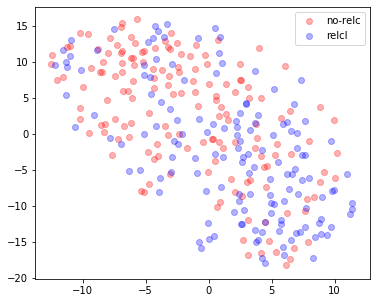

In [25]:
tsne(x_dev[:2500, :], y_dev[:2500], ind2label = {1: "relcl", 0: "no-relc"})

## Predict the presence of REC from the representation

In [29]:
model = LinearSVC(dual = False, max_iter = 10000) #SGDClassifier(max_iter = 200)
model = SGDClassifier(max_iter = 10000, alpha = 0.01)
model.fit(x_train, y_train)
print(model.score(x_dev, y_dev))
print(model.coef_)

0.71
[[ 0.00346046 -0.05922913  0.07079636 ...  0.0158173  -0.23987198
   0.04751878]]


## INLP

In [30]:
inlp_dataset = inlp_dataset_handler.ClassificationDatasetHandler(x_train, y_train, x_dev, y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
#inlp_model_handler = inlp_linear_model.SKlearnClassifier(LinearSVC, {"dual": False, "max_iter": 2000})
inlp_model_handler = inlp_linear_model.SKlearnClassifier(SGDClassifier, {"max_iter": 10000, "alpha": 0.01, "n_iter_no_change": 10})

In [31]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 10, input_dim = 1024, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)

iteration: 9, accuracy: 0.5166666666666667: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


In [32]:
P_rowspace = np.eye(P.shape[0]) - P

In [33]:
relc_vecs = np.array([x for x,y in zip(x_train, y_train) if y == 1])
relc_data = [d for d in data_with_bert_states[:l] if d["label"] == 1]
relc_vecs.shape
relc_vecs_projected = P_rowspace.dot(relc_vecs.T).T

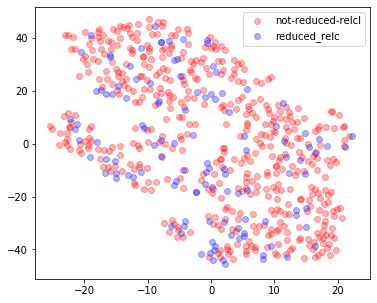

In [34]:
tsne_labels = np.array([1 if d["is_reduced"] else 0 for d in relc_data])
tsne(relc_vecs_projected, tsne_labels, ind2label = {1: "reduced_relc", 0: "not-reduced-relcl"})

In [35]:
Ws[-5]

array([[-0.00646212, -0.0092174 ,  0.01169517, ...,  0.01303763,
        -0.02124622, -0.00875937]])